***

# __Latent Dirichlet Allocation via Stochastic Variational Inference__

_Implementation and application of the algorithm proposed in "Stochastic Variational Inference" (Hoffman et al., 2013) for topic modeling on a Wikipedia-based corpus._

***

## __Introduction__

This project is based on the seminal paper [_Stochastic Variational Inference_](https://www.jmlr.org/papers/volume14/hoffman13a/hoffman13a.pdf) by Hoffman, Blei, Wang and Paisley (2013), which introduces a scalable alternative to classical variational inference by leveraging stochastic optimization techniques.

While the article proposes a general stochastic inference framework for a broad class of probabilistic models, **this project focuses specifically on the case of Latent Dirichlet Allocation (LDA)**. We implement from scratch the version of the SVI algorithm adapted to LDA as presented in the paper.

Our goal is to apply this approach to a real-world task: **unsupervised topic discovery** from a corpus of Wikipedia articles. LDA serves as our underlying probabilistic model for topic modeling, and SVI enables efficient variational inference even with a relatively large dataset.

This notebook walks through the theoretical foundations, the practical implementation of the algorithm, and the analysis of the resulting topics.

***

##  __Notebook Structure__

1. [Overview of Variational Inference](#variational)
2. [Motivation for Stochastic Variational Inference](#svi)
3. [Summary of the Algorithm in the Article](#algo-summary)
4. [Our Approach and Data Preparation](#our-approach)
5. [Latent Dirichlet Allocation (LDA)](#lda)
6. [SVI Algorithm for LDA](#svi-lda)
7. [Model Training and Hyperparameter Choices](#training)
8. [Results Visualization and Interpretation](#results)
9. [Discussion](#discussion)
10. [Conclusion](#conclusion)

In [1]:
# Library imports
import json
import time

import numpy as np
from scipy.special import digamma

# Project modules
from src import *

***

## __1. Overview of Variational Inference__

Variational Inference (VI) is a deterministic technique used to approximate intractable posterior distributions in Bayesian models. Instead of relying on sampling methods like Markov Chain Monte Carlo (MCMC), VI formulates inference as an optimization problem: it seeks the "closest" tractable distribution to the true posterior by minimizing the Kullback–Leibler (KL) divergence.

Mathematically, given a model with observed variables $x$ and latent variables $z$, and a prior distribution $p(z)$, we aim to approximate the posterior $p(z \mid x)$ using a simpler, parameterized distribution $q(z; \lambda)$. The variational parameters $\lambda$ define the shape of this approximate distribution—typically from a family of distributions (e.g., mean-field, fully factorized)—and are optimized to minimize:

$$
\text{KL}(q(z; \lambda) \| p(z \mid x)) \quad \Longleftrightarrow \quad \text{maximize } \mathcal{L}(\lambda) = \mathbb{E}_q[\log p(x, z)] - \mathbb{E}_q[\log q(z; \lambda)]
$$

The right-hand side of this equivalence is known as the **Evidence Lower Bound (ELBO)**. Maximizing the ELBO ensures that the variational distribution $q(z; \lambda)$ becomes a close approximation to the true posterior. It provides a lower bound on the log marginal likelihood $\log p(x)$, which is useful for model selection as well.

The variational parameters $\lambda$ are often vectors of means, variances, or natural parameters depending on the chosen family (e.g., Gaussian, Dirichlet). In practice, they control aspects like the location and spread of the approximate posterior.

Variational inference has been widely adopted due to its computational efficiency and scalability. For instance, in **Latent Dirichlet Allocation (LDA)**, it is used to infer topic distributions for documents and word distributions for topics. In **Bayesian neural networks**, it allows for uncertainty estimation over weights. It is also applied in **hidden Markov models** for unsupervised sequence analysis, and in **probabilistic matrix factorization** for recommendation systems with missing data.

### __How is the ELBO maximized in practice?__

In most practical cases, the ELBO is maximized using one of the following methods:

- **Coordinate Ascent Variational Inference (CAVI)**: Used when the ELBO can be maximized analytically with respect to each group of variables in turn. This is the case for conjugate-exponential models like LDA.
- **Stochastic Gradient Ascent**: When analytical updates are not possible, the gradient of the ELBO is estimated and optimized using stochastic methods (as in SVI).
- **Black-box Variational Inference**: Uses Monte Carlo estimates of the ELBO and its gradient, allowing inference in models without conjugacy.
- **Amortized Variational Inference**: In deep learning contexts, $\lambda$ is predicted by a neural network, trained by maximizing the ELBO (as in VAEs).

These optimization strategies enable variational inference to scale to large and complex probabilistic models.

***

## __2. Motivation for Stochastic Variational Inference__

While classical variational inference techniques are powerful, they come with a major limitation: they require full access to the entire dataset at each iteration of optimization. This makes them computationally expensive and impractical for modern large-scale datasets, such as massive text corpora, image datasets, or streaming data.

In the 2013 paper _Stochastic Variational Inference_, Hoffman et al. introduced a scalable solution by integrating **stochastic optimization** into the variational inference framework. Instead of optimizing the ELBO over the full dataset, SVI performs **updates on small subsets of data (mini-batches)**, using **stochastic gradients** to update the global variational parameters.

SVI thus allows models like LDA, which are traditionally constrained by dataset size, to be trained on **millions of documents** or in **online settings**. Its contribution was particularly timely as data volumes were rapidly increasing in domains like:

- **Natural language processing**, where full document corpora cannot fit in memory
- **Recommender systems**, where user-item matrices are sparse and large
- **Bayesian deep learning**, where combining variational methods with SGD became the foundation of amortized inference

Even today, SVI remains at the core of scalable inference in probabilistic programming frameworks like **Pyro**, **Stan**, and **TensorFlow Probability**.

***

## __3. Summary of the Algorithm from the Paper__

The core idea of Stochastic Variational Inference is to split the variational parameters into:
- **Global parameters** (e.g., topic-word distributions in LDA, denoted by $\lambda$)
- **Local parameters** (e.g., per-document topic proportions $\gamma$ and word-topic assignments $\phi$)

Rather than computing updates for the entire dataset at once, the algorithm processes one document (or mini-batch) at a time. The main steps are:

### __Iterative Algorithm Structure__

1. **Sample a document** from the corpus.
2. **Initialize local variational parameters**: $\gamma_d$, $\phi_{dn}$.
3. **Local E-step**: Iteratively update $\phi_{dn}$ and $\gamma_d$ until convergence:
    $$
    \phi_{dn}^k \propto \exp(\mathbb{E}_q[\log \theta_{dk}]) \cdot \exp(\mathbb{E}_q[\log \beta_{kw_{dn}}])
    $$
    $$
    \gamma_d = \alpha + \sum_n \phi_{dn}
    $$
4. **Compute intermediate global statistics**:
    $$
    \hat{\lambda}_k = \eta + D \sum_n \phi_{dn}^k \cdot \mathbf{1}_{w_{dn} = v}
    $$
5. **Update global parameters** via an exponentially weighted moving average:
    $$
    \lambda^{(t)} = (1 - \rho_t) \cdot \lambda^{(t-1)} + \rho_t \cdot \hat{\lambda}
    $$
    with learning rate $\rho_t = (\tau + t)^{-\kappa}$, where $\tau > 0$ and $\kappa \in (0.5, 1]$.

This update rule is inspired by Robbins-Monro stochastic approximation and ensures convergence under mild conditions. The full algorithm is memory-efficient, scalable, and converges to a local optimum of the ELBO.

The strength of SVI lies in its generality: it can be applied to any model in the **conjugate exponential family**, and later extensions broadened its applicability to non-conjugate settings.

***

## __4. Our Approach and Data Preparation__

To evaluate the Stochastic Variational Inference algorithm on a realistic task, we applied it to **unsupervised topic modeling** using **Latent Dirichlet Allocation (LDA)**.


### __Corpus Construction__

We built a custom dataset of Wikipedia articles using 8 thematic seeds:

- `business`, `culture`, `history`, `internet`, `language`, `nature`, `politics`, `sports`

Using the function `create_wikipedia_corpus()` from `src/data_extraction.py`, we aimed to retrieve approximately **150 articles per seed**, resulting in a corpus of around **1200 articles**. Some articles could not be extracted due to disambiguation or page errors and were automatically skipped.


### __Text Preparation__

The text data was processed using `vectorize_texts()` from `src/data_preparation.py`, which performs:

- Tokenization and lowercasing
- Stopword removal
- Filtering of short or non-alphabetic words
- Vocabulary construction (top 10,000 words)
- Bag-of-words vectorization

The final corpus is a list of vectorized documents (lists of word IDs) along with a shared vocabulary dictionary. This format serves as input to the SVI-LDA model.

In [2]:
# Load the Wikipedia corpus
with open("data/wikipedia_corpus.json", "r", encoding="utf-8") as f:
    wiki_articles = json.load(f)

texts = [article["content"] for article in wiki_articles.values()] # Extract the content of the articles
titles = [article["title"] for article in wiki_articles.values()] # Extract the title title of the articles
corpus, vocab = vectorize_texts(texts) # Text vectorization

V = len(vocab) # Vocabulary size

***

## __5. Latent Dirichlet Allocation (LDA)__

Latent Dirichlet Allocation (LDA) is a generative probabilistic model introduced by Blei et al. (2003) to uncover latent thematic structures in large document collections.

### __Generative Process__

LDA assumes the following process for generating a corpus:

1. For each topic $k \in \{1, ..., K\}$:
   - Draw a word distribution: $\beta_k \sim \text{Dirichlet}(\eta)$
2. For each document $d$:
   - Draw a topic distribution: $\theta_d \sim \text{Dirichlet}(\alpha)$
   - For each word $n$ in document $d$:
     - Draw a topic assignment: $z_{dn} \sim \text{Multinomial}(\theta_d)$
     - Draw a word: $w_{dn} \sim \text{Multinomial}(\beta_{z_{dn}})$

The model is fully specified by the priors $\alpha$ and $\eta$, the number of topics $K$, and the vocabulary size $V$.

In LDA, both the topic-word distributions $\beta_k$ and the document-topic distributions $\theta_d$ are **latent variables** that we wish to infer given the observed words $w_{dn}$. The true posterior $p(\beta, \theta, z \mid w)$ is intractable, which motivates the use of variational inference.

### __The Role of the Dirichlet Distribution__

The Dirichlet prior is key to LDA:
- It controls the **sparsity** of topic distributions in documents ($\theta_d$) and word distributions in topics ($\beta_k$).
- A small value of $\alpha$ results in documents focusing on fewer topics; a small $\eta$ leads to topics focused on fewer words.

In our implementation, we approximate these distributions variationally, using parameters $\gamma$ (for $\theta$) and $\lambda$ (for $\beta$), which are optimized during training.

***

## __6. SVI Algorithm for LDA — Our Implementation__

We implemented the Stochastic Variational Inference algorithm specifically tailored to LDA, following the steps described in the original paper. The core variational parameters are:

- $\lambda_{kv}$: parameters for the topic-word distributions (global)
- $\gamma_d$: Dirichlet parameters for the topic mixture of document $d$ (local)
- $\phi_{dn}$: variational probabilities that word $n$ in document $d$ is assigned to topic $k$

### __Key steps in our implementation:__

1. **Initialize** $\lambda$ with small random positive values (from a Gamma distribution).
2. **Repeat for $t = 1$ to $max\_iter$**:
   - Sample one document $d$ from the corpus.
   - Initialize $\gamma_d$ and $\phi_{dn}$.
   - Run the **E-step** for $e\_step\_iter$ iterations:
     - Update $\phi_{dn}$ using:
       $$
       \phi_{dn}^k \propto \exp\left(\mathbb{E}_q[\log \theta_{dk}] + \mathbb{E}_q[\log \beta_{kw_{dn}}]\right)
       $$

       #### __Computing the expectations:__
       The two expected log terms are computed as follows:
       - For the document-specific topic distribution:
         $$
         \mathbb{E}_q[\log \theta_{dk}] = \psi(\gamma_{dk}) - \psi\left(\sum_{j=1}^K \gamma_{dj}\right)
         $$
       - For the topic-specific word distribution:
         $$
         \mathbb{E}_q[\log \beta_{kw_{dn}}] = \psi(\lambda_{k w_{dn}}) - \psi\left(\sum_{v=1}^V \lambda_{k v}\right)
         $$

       where $\psi$ is the **digamma function**, i.e., the derivative of the log gamma function.

       These expectations reflect the current beliefs about:
       - how likely document $d$ uses topic $k$ (via $\gamma_d$),
       - how likely topic $k$ generates word $w_{dn}$ (via $\lambda_k$).

     - Normalize $\phi_{dn}$ over all $k$ to ensure it sums to 1.
     - Update $\gamma_d$ using:
       $$
       \gamma_d = \alpha + \sum_n \phi_{dn}
       $$

3. **Compute the intermediate global statistics** $\hat{\lambda}$:
   $$
   \hat{\lambda}_{kv} = \eta + D \cdot \sum_n \phi_{dn}^k \cdot \mathbf{1}_{w_{dn} = v}
   $$

4. **Update the global parameters**:
   $$
   \lambda^{(t)} = (1 - \rho_t) \cdot \lambda^{(t-1)} + \rho_t \cdot \hat{\lambda}
   $$
   with learning rate:
   $$
   \rho_t = (\tau + t)^{-\kappa}
   $$

Our implementation also tracks the topic proportions $\theta_d = \gamma_d / \sum_k \gamma_d^k$ for each document to enable downstream analysis.

In [3]:
def log_dirichlet_expectation(alpha):
    """
    Computes the expectation of the log of a Dirichlet distribution.

    Args:
        alpha (np.ndarray): Dirichlet parameters, 1D or 2D array.

    Returns:
        np.ndarray: Expected log values of the Dirichlet-distributed variables.
    """
    if len(alpha.shape) == 1:
        return digamma(alpha) - digamma(np.sum(alpha))
    return digamma(alpha) - digamma(np.sum(alpha, axis=1))[:, np.newaxis]

In [4]:
def SVI_for_LDA(documents, V, K=10, alpha=1.0, eta=1.0, max_iter=100, tau=64, kappa=0.7, e_step_iter=20, verbose=2):
    """
    Trains a Latent Dirichlet Allocation (LDA) model using Stochastic Variational Inference (SVI).

    Args:
        documents (list of list of int): Corpus as lists of word indices.
        V (int): Vocabulary size.
        K (int, optional): Number of topics. Defaults to 10.
        alpha (float, optional): Dirichlet prior for document-topic distribution. Defaults to 1.0.
        eta (float, optional): Dirichlet prior for topic-word distribution. Defaults to 1.0.
        max_iter (int, optional): Number of training iterations. Defaults to 100.
        tau (float, optional): Learning rate delay. Defaults to 64.
        kappa (float, optional): Learning rate decay factor (0.5 < kappa ≤ 1). Defaults to 0.7.
        e_step_iter (int, optional): Number of E-step iterations per document. Defaults to 20.
        verbose (int, optional): Verbosity level (0=silent, 1=summary, 2=full). Defaults to 2.

    Returns:
        tuple:
            - np.ndarray: Learned topic-word distribution matrix (lambda).
            - dict: Mapping from document titles to topic distributions.
    """
    D = len(documents)
    lambd = np.random.gamma(100., 1./100., size=(K, V))

    doc_topic_distrib = {}

    start_training_time = time.time() 
    for t in range(max_iter):
        if verbose >= 2:
            start_iteration_time = time.time() 

        doc_id = np.random.randint(0, D)
        doc = documents[doc_id]
        N = len(doc)

        gamma = np.ones(K)
        phi = np.full(shape=(N, K), fill_value=1/K)

        E_logbeta = log_dirichlet_expectation(lambd)
        exp_E_logbeta = np.exp(E_logbeta)

        for _ in range(e_step_iter):
            E_logtheta = log_dirichlet_expectation(gamma)
            exp_E_logtheta = np.exp(E_logtheta)

            for n, w in enumerate(doc):
                phi[n, :] = exp_E_logtheta * exp_E_logbeta[:, w]
                phi[n, :] /= np.sum(phi[n, :])
            
            gamma = alpha + np.sum(phi, axis=0)

            theta = gamma / np.sum(gamma)
            doc_topic_distrib[titles[doc_id]] = theta

        topic_word_contrib = np.zeros(shape=(K, V))
        for n, w in enumerate(doc):
            topic_word_contrib[:, w] += phi[n, :]

        lambd_hat = eta + D*topic_word_contrib

        rho = (t + tau) ** -kappa
        lambd = (1 - rho) * lambd + rho * lambd_hat

        if verbose >= 2:
            iteration_time = time.time() - start_iteration_time
            print(f"\t - Iteration {t} done in {iteration_time:.2f}s.")

    if verbose >= 1:
        training_time = time.time() - start_training_time
        print(f"Training done in {training_time:.2f}s.")

    return lambd, doc_topic_distrib

***

## __7. Model Training and Hyperparameter Choices__

We trained our LDA model using SVI with the following settings:

- Number of topics: $K = 10$
- Vocabulary size: $V = 10,000$
- Document-topic prior: $\alpha = 1.0$
- Topic-word prior: $\eta = 1.0$
- Learning rate parameters: $\tau = 100$, $\kappa = 0.7$
- Iterations: $T = 500$
- Local E-step iterations: 30

### __Why these choices?__

- A value of $K = 10$ allows us to explore granularity beyond the 8 initial themes (seeds).
- $\alpha = 1.0$ encourages documents to mix several topics without being too uniform.
- $\eta = 1.0$ allows each topic to cover a reasonable range of vocabulary without being overly concentrated.
- $\tau$ and $\kappa$ control how quickly the algorithm adapts to new documents: higher $\tau$ slows early updates, $\kappa = 0.7$ is a standard decay rate that ensures convergence.

These values were chosen following Hoffman et al.'s recommendations and through empirical validation during development.

In [5]:
lambd, doc_topic_distrib = SVI_for_LDA(
    corpus,
    V,
    K=10,
    alpha=1.0,
    eta=1.0,
    max_iter=500,
    tau=100,
    kappa=0.7,
    e_step_iter=30,
    verbose=1
)

Training done in 252.59s.


***

## __8. Results Visualization and Interpretation__

After training our SVI-LDA model for 500 iterations on a corpus of ~430 Wikipedia articles across 8 thematic seeds, we analyze the learned latent topic structure along three axes.

### __8.1. Topic-Word Distributions ($\lambda$)__

We extract and visualize the most probable words for each topic from the learned matrix $\lambda$.

- **Top 100 words per topic** are presented in tabular format for inspection.
- **Word clouds** for each topic help highlight visually dominant terms.

In [6]:
top_words = get_top_words(lambd, vocab)
top_words

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Rank,,,,,,,,,,
1,first,government,russian,sports,iot,politics,language,internet,sexual,culture
2,series,australia,iran,league,devices,political,languages,business,nature,also
3,history,war,social,team,used,party,occitan,network,hookup,art
4,new,new,century,penn,data,women,used,also,one,century
5,two,south,also,world,systems,united,also,company,sex,world
...,...,...,...,...,...,...,...,...,...,...
96,including,thailand,became,playoffs,large,legal,published,health,based,italian
97,moved,year,central,including,changes,local,according,communications,person,great
98,greatest,called,culture,australia,voip,legislation,endangered,cost,external,america


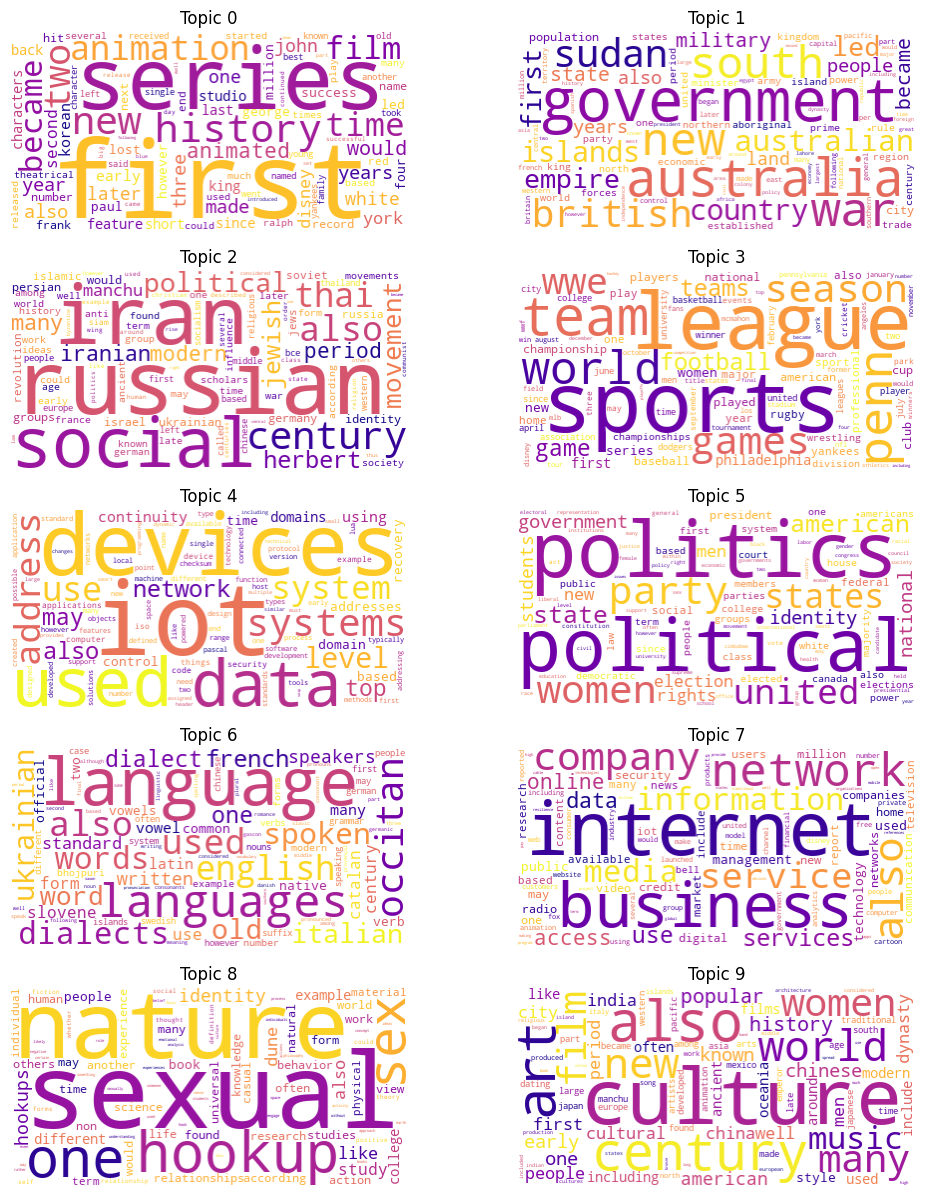

In [7]:
plot_top_words_wordcloud(lambd, vocab, n_wordcloud=10)

These outputs confirm that several topics align semantically with real-world themes. For example:
- Topic 0 contains _history_, _century_, _chinese_, _world_ → linked to historical narratives.
- Topic 3 is dominated by _sports_, _team_, _league_, _championship_ → clearly sports-related.
- Topic 6 contains _internet_, _data_, _network_, _web_ → related to digital/technology topics.
- Topic 5 highlights _nature_, _law_, _human_ → suggesting philosophical or natural science debates.


### __8.2. Document-Topic Distributions ($\theta$)__

From the variational parameters $\gamma_d$, we compute the topic proportions $\theta_d$ for each document. This allows us to:

- Identify the **dominant topic per document**
- Visualize the **overall distribution of dominant topics** in the corpus using a pie chart

In [8]:
docs_info = get_topic_distrib_info(doc_topic_distrib, wiki_articles)
docs_info

,Article,Seed,Top topic,Topic 0 proportion,Topic 1 proportion,Topic 2 proportion,Topic 3 proportion,Topic 4 proportion,Topic 5 proportion,Topic 6 proportion,Topic 7 proportion,Topic 8 proportion,Topic 9 proportion
0,History of cricket,history,3,8.79,10.86,9.46,13.96,8.25,10.69,9.44,10.71,7.78,10.05
1,History of life,history,8,12.54,3.82,10.80,1.11,20.27,4.55,9.20,2.76,29.34,5.61
2,Clear History,history,7,1.21,9.99,2.33,23.96,0.72,13.97,2.60,34.61,0.64,9.97
3,Dominica,nature,1,1.49,42.27,1.83,14.90,0.24,14.18,3.49,8.39,0.11,13.10
4,Catalan language,language,6,1.05,11.97,14.22,0.06,0.05,0.14,71.46,0.08,0.04,0.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,Internet outage,internet,7,0.87,6.07,0.62,0.23,22.04,2.33,0.30,56.04,11.02,0.49
391,Nature Methods,nature,8,3.16,2.09,1.57,6.51,2.57,3.09,2.43,29.31,47.43,1.83
392,History of animation,history,0,48.98,0.04,0.75,3.00,2.62,0.07,0.09,14.12,4.98,25.35
393,Business consultant,business,7,1.48,1.39,1.87,2.02,4.40,12.18,1.80,64.99,8.87,0.98


In [9]:
plot_topics_distrib(docs_info)

From this view, we observe a **balanced but slightly uneven distribution** of topic dominance. The top 3 topics (Topic 1, 2, 0) represent the majority of the documents, while Topic 8 is relatively underrepresented.

### __8.3. Topic Distribution by Seed (Themes)__

Using the original thematic seeds (e.g., “sports”, “internet”, “language”), we assess the model's ability to capture semantic groupings.

- A **stacked bar chart** shows the proportion of each topic per seed
- A **table** summarizes the number of documents assigned to each topic per seed

In [10]:
topics_by_seed = plot_topics_distrib_by_seed(docs_info)
topics_by_seed

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9
Seed,,,,,,,,,,
business,0,1,0,5,0,4,1,34,0,4
culture,0,2,2,0,1,1,0,2,9,30
history,6,22,1,5,0,2,1,4,2,11
internet,1,1,0,2,8,0,0,36,0,0
language,0,0,0,0,7,0,36,0,1,1
nature,5,4,0,1,0,1,1,4,26,3
politics,0,12,8,0,0,33,1,1,1,1
sports,1,0,1,43,0,0,0,3,0,2


This comparison reveals interesting alignment:
- The _sports_ seed is heavily associated with Topic 3 (sports) and Topic 2.
- The _internet_ seed is clearly captured by Topic 6.
- The _language_ seed almost entirely maps to Topic 9 (language, dialects).
- Topics 0, 1, and 2 appear more generic, spreading across seeds like _culture_, _history_, and _business_.

This confirms that the model successfully uncovered latent themes that align—often cleanly—with the original seed concepts.

### __8.4. Topic Evaluation Metrics__

To quantitatively evaluate the quality and distinctiveness of the inferred topics, we compute two complementary metrics:

- **Cohérence des topics (c_v)**: Measures how semantically coherent the top words of each topic are, based on word co-occurrence in the original documents. A higher score indicates better interpretability.

- **Jensen-Shannon divergence (JS)**: Measures the average dissimilarity between topic-word distributions. A higher score suggests that topics are more distinct from one another.

We use the `gensim` library to compute coherence, and `scipy` for divergence.

In [11]:
cv_score = compute_topic_coherence(lambd, vocab, corpus)
js_score = compute_average_js_divergence(lambd)

print(f"Topic Coherence (c_v): {cv_score:.2f}.")
print(f"Average topic JS divergence: {js_score:.2f}.")

Topic Coherence (c_v): 0.48.
Average topic JS divergence: 0.58.


***

## __9. Discussion__

The results of our SVI-based LDA model provide strong evidence of meaningful structure discovery in our Wikipedia corpus. Here's an evaluation of the performance and insights:

### __What works well:__

- **Coherence of topics**: Many topics present interpretable and semantically grouped top words. For instance, Topic 3 (sports) and Topic 6 (internet) exhibit strong internal consistency.
- **Alignment with seeds**: There is a noticeable correlation between the original seed categories and the dominant topics inferred, especially for clear domains like “sports” and “language”.
- **Balanced training**: The pie chart distribution of dominant topics shows that the model does not collapse into a single theme, and explores a range of semantic spaces.
- **Quantitative metrics**:
  - **Topic Coherence**: The model reaches a score of $c_v ≈ 0.48$. This is a reasonable result given the size and heterogeneity of the corpus, indicating moderate topic interpretability.
  - **Jensen-Shannon divergence**: With an average score of ≈ 0.58, topics are sufficiently distinct from each other, suggesting the model captures meaningful separations in word distributions.

### __Observed limitations:__

- **Topic interpretability varies**: While some topics are clearly coherent, others are broader or overlap semantically. Topics 0, 1 and 2 tend to capture more generic language.
- **Moderate coherence score**: Although acceptable, the coherence score (~0.48) suggests that further refinement (e.g., on hyperparameters or preprocessing) could improve topic quality.
- **Ambiguity in some seeds**: Seeds like "culture" or "history" yield articles that span several topics, resulting in more diffuse assignments.

### __What could improve:__

- **Tune the topic-word prior ($\eta$)**: Reducing $\eta$ from 1.0 to 0.1 might encourage sparser and more interpretable topics.
- **Try different values of $K$**: Exploring a higher number of topics (e.g., $K=12$ or $K=15$) could help specialize broad clusters.
- **Enhance preprocessing**: Removing very high-frequency or semantically weak terms (e.g., "may", "also") could sharpen topics.
- **Evaluate across more metrics**: Computing NPMI, UMass or topic diversity would provide a broader picture of the model’s quality.

In short, the model produces meaningful and partially interpretable results, with solid separation between topics. Further refinements could help boost coherence and clarify ambiguous cases.

***

## __10. Conclusion__

This project demonstrates a full end-to-end implementation of **Stochastic Variational Inference (SVI)** as introduced in Hoffman et al. (2013), with a concrete application to topic modeling using **Latent Dirichlet Allocation (LDA)**.

We:
- Built a structured Wikipedia corpus of ~1200 articles across 8 themes
- Preprocessed and vectorized the text using a controlled vocabulary
- Implemented the SVI algorithm from scratch with local and global variational updates
- Visualized and interpreted the results using modern tools
- Evaluated the model using both visual and quantitative metrics (topic coherence and divergence)

### __Key takeaways:__
- SVI allows scalable inference for large-scale probabilistic models like LDA
- Even with a moderately sized corpus, meaningful and interpretable topics can emerge
- Probabilistic models benefit from careful hyperparameter tuning and corpus structure
- Evaluation metrics like coherence ($c_v$) and topic divergence are helpful to assess quality objectively

### __Future directions:__
- Use coherence and diversity metrics to automate topic quality evaluation
- Extend the model to dynamic topic models (e.g., DTM or HDP)
- Apply SVI to other probabilistic models (e.g., Variational Autoencoders)
- Integrate this pipeline into an interactive topic exploration tool (e.g., using Streamlit or Dash)

This implementation reinforces the utility of variational methods in modern probabilistic inference, offering both scalability and interpretability when applied thoughtfully.

***